# DEDT Lumi through ECMWF Polytope API

The EMCWF Polytope API now supports bespoke geometry definions in queries.

`eodag` supports this feature via de `geom` parameter for the `dedt_lumi` provider.

In [1]:
from eodag import EODataAccessGateway
import json

dag = EODataAccessGateway()

result = dag.search(
    provider="dedt_lumi",
    start="2021-01-01",
    productType="DT_CLIMATE_ADAPTATION",
    geom={'lonmin': 22, 'latmin': 18, 'lonmax': 37, 'latmax': 45},
)

result

SearchResult([EOProduct(id=DT_CLIMATE_ADAPTATION_ORDERABLE_c9ed022bda4820372d1eda2f3105d47a8a6396ad, provider=dedt_lumi)])

Let's download this product and check its data.

In [2]:
path = result[0].download(output_dir='/tmp')

!tree {path}

0.00B [00:00, ?B/s]

/tmp/DT_CLIMATE_ADAPTATION_a6764da7-9c5c-472d-a884-e965d127423f
└── DT_CLIMATE_ADAPTATION_a6764da7-9c5c-472d-a884-e965d127423f.covjson

1 directory, 1 file


When requesting a RoI, ECMWF Polytope will generate a `covjson` file.

To plot it, we are going to load it into an `xarray` dataset.

In [3]:
import os
import json
from covjsonkit.api import Covjsonkit

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cov_json_path = os.path.join(path, os.listdir(path)[0])

with open(cov_json_path) as f:
    covjson = json.load(f)

# Load CovJson using covjsonkit into an xarray
decoder = Covjsonkit().decode(covjson)
ds = decoder.to_xarray()

ds

<xarray.Dataset> Size: 6MB
Dimensions:    (datetimes: 1, number: 1, steps: 1, points: 104351)
Coordinates:
  * datetimes  (datetimes) <U20 80B '2021-01-01 00:00:00Z'
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 0
  * points     (points) int64 835kB 0 1 2 3 4 ... 104347 104348 104349 104350
    latitude   (points) float64 835kB 18.01 18.01 18.01 ... 44.99 44.99 44.99
    longitude  (points) float64 835kB 22.06 22.15 22.24 ... 36.8 36.89 36.98
    levelist   (points) float64 835kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    sp         (datetimes, number, steps, points) float64 835kB 9.549e+04 ......
    10u        (datetimes, number, steps, points) float64 835kB -5.133 ... 4.259
    10v        (datetimes, number, steps, points) float64 835kB -0.9033 ... 8...
Attributes: (12/15)
    activity:     scenariomip
    class:        d1
    dataset:      climate-dt
    experiment:   ssp3-7.0
    expver:       0001
    generation:   1
    ...           ...
    resolution:   high
    stream:       clte
    type:         fc
    number:       0
    step:         0
    date:         2021-01-01 00:00:00Z

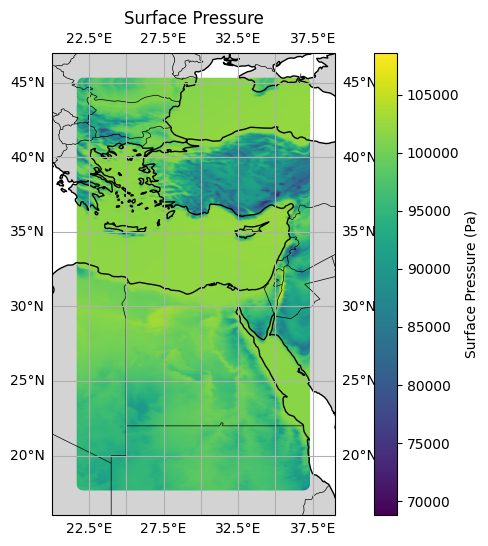

In [4]:
# Extracting sp variable from dataset
# Data in the original covjson is organize in points rather than lat/lon variables
# so we plot as scatter.

sp = ds['sp'].isel(datetimes=0, number=0, steps=0).values
lats = ds['latitude'].values
lons = ds['longitude'].values

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

sc = ax.scatter(lons, lats, c=sp, s=40, cmap='viridis',
                transform=ccrs.PlateCarree())

plt.colorbar(sc, orientation='vertical', label='Surface Pressure (Pa)')

margin = 2
ax.set_extent([
    lons.min()-margin, lons.max()+margin,
    lats.min()-margin, lats.max()+margin
], crs=ccrs.PlateCarree())

plt.title("Surface Pressure")
plt.show()